In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import numpy as np
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
from tqdm import tqdm

In [40]:
N = 10**5 # Training samples
K = 10 # Nodes
M = 10**5 # Iterations
total_time = 5 # Number of hours
dt = 10/60 # 10 minute increments
T = int(total_time/dt) # timesteps
num_hiddens = 10

sigma = 10**9 # Penalty coefficient
phi = 10 # Cost of waiting per person per time increment
gamma_b = 380 # Max capacity of buses at each time increment

inp = tf.placeholder(dtype = tf.float32, shape = (None, 1))

ix = {
    "rb":0,
    "rw":1,
    "wb":2
}

/Users/aliceharting/tf1_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


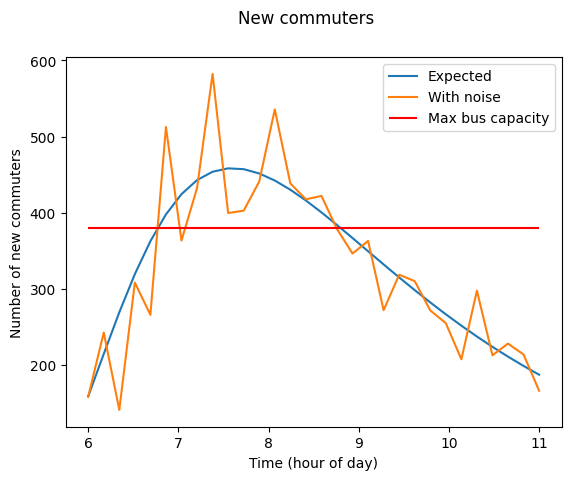

In [50]:
# Generate new commuters
population = 10**4

x = np.linspace(2, 7, T)
y = invgamma.pdf(x=x, a=4, scale=18)
rclean = y/np.sum(y)*population
r = rclean + 50*norm.rvs(size=(N, T)) # Model training data

# Plot
x = x + 4
fig, ax = plt.subplots()
ax.plot(x,rclean, label="Expected")
ax.plot(x,r[0,:], label="With noise")
ax.hlines(gamma_b, xmin=6, xmax=11, label="Max bus capacity", color="red")
ax.legend()
ax.set_xlabel("Time (hour of day)")
ax.set_ylabel("Number of new commuters")
fig.suptitle("New commuters")
fig.savefig("img/rtest.png")
fig.show()

/Users/aliceharting/tf1_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


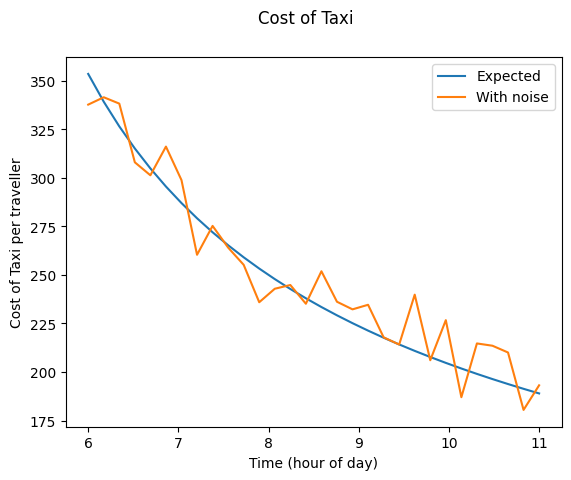

In [42]:
# Generate taxi costs
fig, ax = plt.subplots()
x = np.linspace(2, 7, T)
y = 1/np.sqrt(x)
kclean = y*5*10**2
k = kclean + 10*norm.rvs(size=(N, T))

ax.plot(x+4,kclean, label="Expected")
ax.plot(x+4,k[0,:], label="With noise")
ax.legend()
ax.set_xlabel("Time (hour of day)")
ax.set_ylabel("Cost of Taxi per traveller")
xticks = [6, 7, 8, 9, 10, 11]
ax.set_xticks(xticks, [f"{tick}" for tick in xticks])
fig.suptitle("Cost of Taxi")
fig.savefig("img/k.png")
fig.show()

In [43]:
r_inp = tf.placeholder(dtype = tf.float32, shape = (1, T))
k_inp = tf.placeholder(dtype = tf.float32, shape = (1, T))

def c_t(w_t, a_t, r_t, k_t):
    a_rt_t = r_t - (a_t[:,ix["rw"]] + a_t[:,ix["rb"]])
    return phi*w_t + k_t*a_rt_t

def w_next(w_t, a_t):
    return w_t + a_t[:,ix["rw"]] - a_t[:,ix["wb"]] 

def pen(w_t, a_t, r_t):
    constr = sigma*tf.minimum(0.0, gamma_b - (a_t[:,ix["rb"]] + a_t[:,ix["wb"]]))**2
    constr += sigma*tf.minimum(0.0, r_t - (a_t[:,ix["rw"]] + a_t[:,ix["rb"]]))**2
    constr += sigma*tf.minimum(0.0, w_t - a_t[:,ix["wb"]])**2
    return constr

def neural_network_model(r_inp, k_inp):
    initializer = tf.initializers.random_normal
    activation_fcn_1 = tf.nn.sigmoid
    activation_fcn_output = tf.nn.relu
    num_output_nodes = 3 # Number of control elements (a_rt is computed directly as r - a_rw - a_rb)
    
    cost = 0
    output = []  # Create an empty list to store a_t values for each time step
    w_t = tf.zeros(dtype = tf.float32, shape = (1, 1)) # Starting value
    
    for t in range(T):
        # Input is state
        layer_input = w_t
        for n in range(num_hiddens):
            hidden = tf.layers.dense(inputs=layer_input,
                                             units=K,
                                             activation=activation_fcn_1,
                                             kernel_initializer=initializer())
            layer_input = hidden
            
        # Output is control   
        a_t = tf.layers.dense(inputs=layer_input,
                              units=num_output_nodes,
                              activation=activation_fcn_output,
                              use_bias=False,
                              kernel_initializer=initializer())
        
        output.append(a_t)
        
        # Compute the cost
        cost += c_t(w_t, a_t, r_inp[:,t], k_inp[:,t]) + pen(w_t, a_t, r_inp[:,t])

        # Compute the new input (state) from the control
        w_t = w_next(w_t, a_t)
    
    output.append(cost)
    return output

def train_neural_network(sess):
    output = neural_network_model(r_inp, k_inp)
    cost = tf.reduce_mean(output[-1])
    optimizer = tf.train.AdamOptimizer()
    train = optimizer.minimize(cost)
    E_1 = []
    
    sess.run(tf.global_variables_initializer())
    
    for m in tqdm(range(0, M)):
        n = np.random.randint(0, N)
        r_in = np.reshape(r[n, :], (1,T))
        k_in = np.reshape(k[n, :], (1,T))
        sess.run(train, feed_dict = {r_inp:r_in, k_inp:k_in})        
        if m % int(M/100) == 0:
            E_1.append(cost.eval(feed_dict={r_inp:r_in, k_inp:k_in}))
            
    return output, E_1

In [44]:
optimal_control = {key:[] for key in list(ix.keys()) + ["rt"]}
r_in = np.reshape(r[0, :], (1,T))
k_in = np.reshape(k[0, :], (1,T))

with tf.Session() as sess:
    output, E_1 = train_neural_network(sess)
    for t in range(T):
        for key, value in ix.items():
            optimal_control[key].append(output[t].eval(feed_dict={r_inp:r_in, k_inp:k_in})[:,value])
        optimal_control["rt"].append(r_in[:,t] - optimal_control["rw"][-1] - optimal_control["rb"][-1])

100%|███████████████████████████████████| 100000/100000 [33:22<00:00, 49.95it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/aliceharting/tf1_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == "":


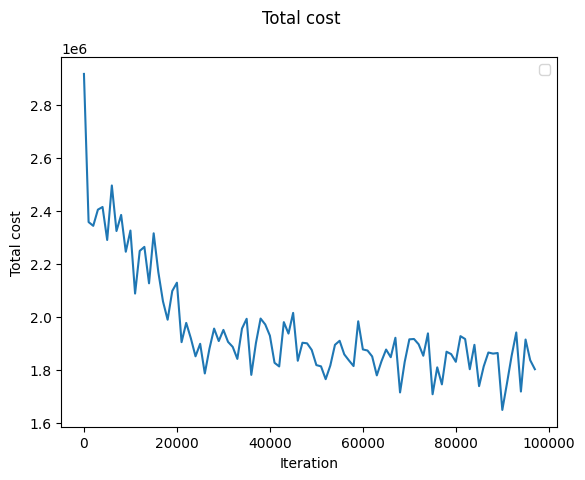

In [45]:
# Plot total cost by iteration
fig, ax = plt.subplots()
fig.suptitle("Total cost")
pe = [x for x in E_1 if x/10**6<5]
ax.plot(range(len(pe)), pe)
ax.legend()
ax.set_ylabel("Total cost")
ax.set_xlabel("Iteration")
xticks = [0, 20, 40, 60, 80, 100]
ax.set_xticks(xticks, [f"{tick*int(M/len(E_1))}" for tick in xticks])
fig.savefig("img/error.png")
fig.show()

/Users/aliceharting/tf1_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/aliceharting/tf1_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


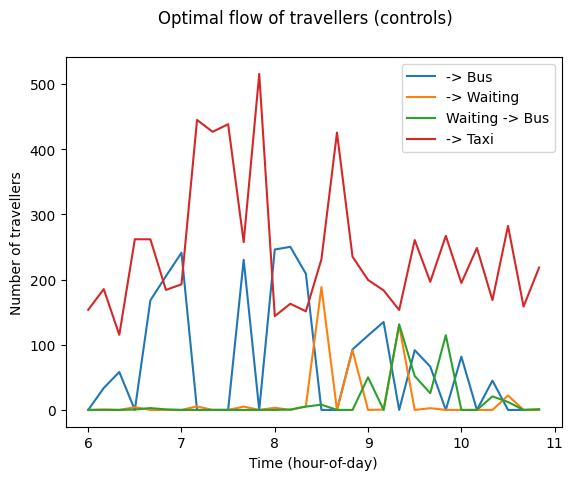

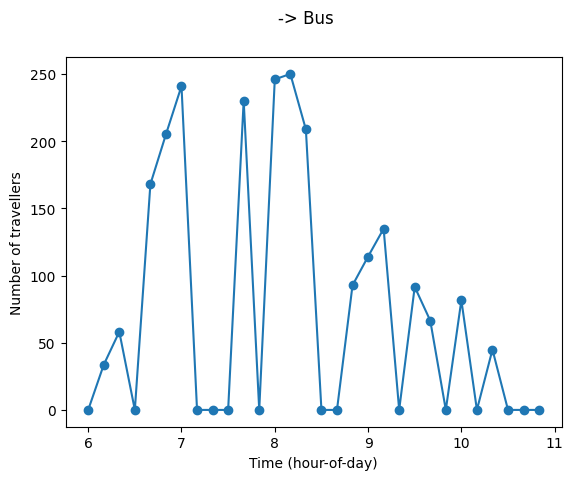

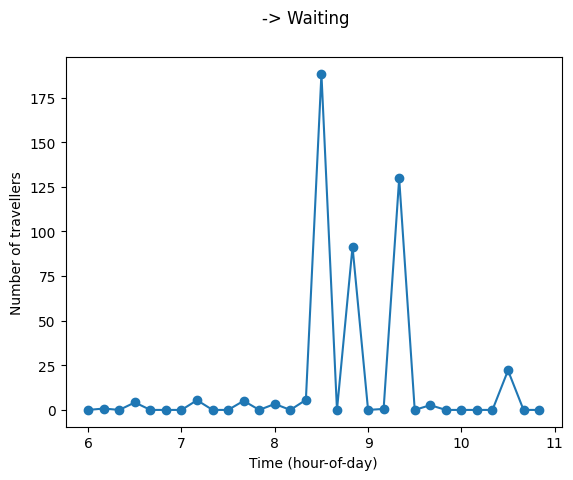

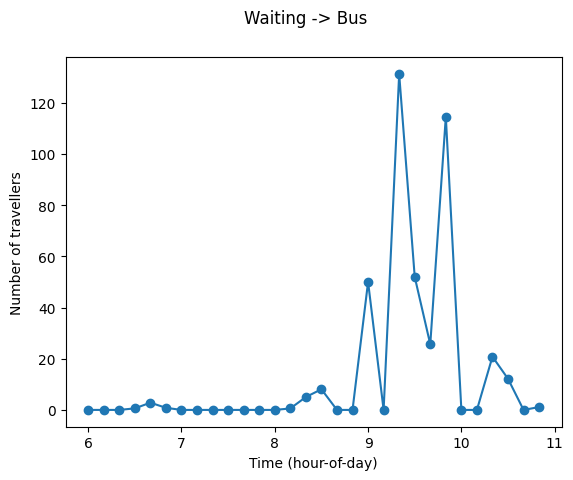

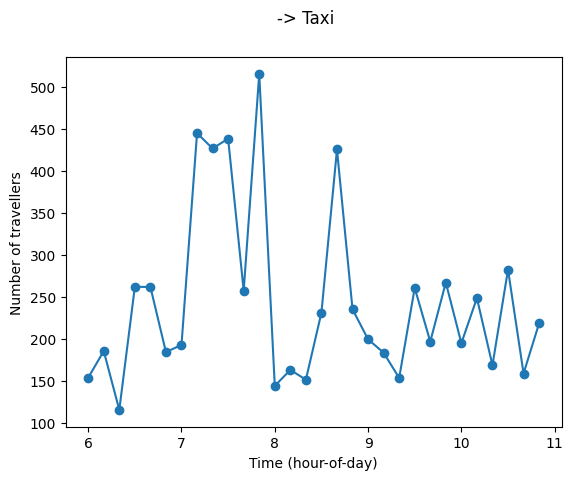

In [46]:
labels = {
    "rt": "-> Taxi",
    "rb": "-> Bus",
    "rw": "-> Waiting",
    "wb": "Waiting -> Bus"
}

# Plot optimal controls
xticks = [6*i for i in range(0,6)]
fig, ax = plt.subplots()
for key, value in optimal_control.items():
    fig2, ax2 = plt.subplots()
    x = range(T)
    y = np.squeeze(np.array(value).transpose())
    ax.plot(x, y, label=f"{labels[key]}")
    ax2.plot(x, y, "o-")
    ax2.set_xticks(xticks, [f"{int(tick/6)+6}" for tick in xticks])
    fig2.suptitle(f"{labels[key]}")
    ax2.set_xlabel("Time (hour-of-day)")
    ax2.set_ylabel("Number of travellers")
    fig2.savefig(f"a_{key}.png")
    fig2.show()
ax.legend()
ax.set_xlabel("Time (hour-of-day)")
ax.set_ylabel("Number of travellers")
ax.set_xticks(xticks, [f"{int(tick/6)+6}" for tick in xticks])
fig.suptitle("Optimal flow of travellers (controls)")
fig.savefig("img/control.png")
fig.show()

/Users/aliceharting/tf1_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == "__main__":


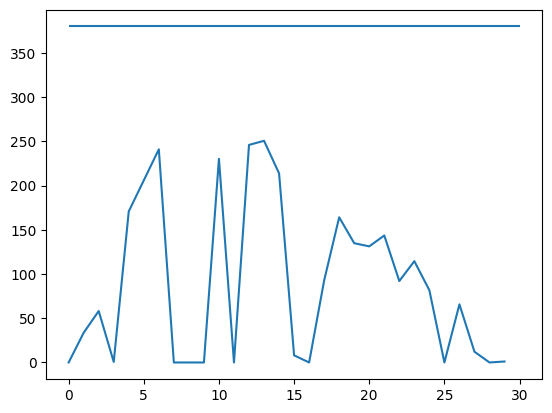

In [47]:
# Check the bus load constraint
rb = optimal_control["rb"]
wb = optimal_control["wb"]
fig2, ax2 = plt.subplots()
x = range(T)
y = np.squeeze(np.array(rb).transpose())+np.squeeze(np.array(wb).transpose())
ax2.plot(x, y, label=f"{labels[key]}")
ax2.hlines(gamma_b, xmin=0, xmax=T)
fig2.show()

In [48]:
np.sort(E_1)

array([1.6494895e+06, 1.7086340e+06, 1.7154751e+06, 1.7188158e+06,
       1.7391319e+06, 1.7458629e+06, 1.7496909e+06, 1.7655064e+06,
       1.7798285e+06, 1.7817589e+06, 1.7869602e+06, 1.8029539e+06,
       1.8030946e+06, 1.8101292e+06, 1.8135341e+06, 1.8138041e+06,
       1.8138451e+06, 1.8149370e+06, 1.8170400e+06, 1.8186265e+06,
       1.8273148e+06, 1.8304859e+06, 1.8310132e+06, 1.8328751e+06,
       1.8349151e+06, 1.8362928e+06, 1.8371256e+06, 1.8420346e+06,
       1.8483382e+06, 1.8513709e+06, 1.8517721e+06, 1.8532880e+06,
       1.8539055e+06, 1.8590968e+06, 1.8599924e+06, 1.8619891e+06,
       1.8642122e+06, 1.8661044e+06, 1.8691092e+06, 1.8736371e+06,
       1.8757401e+06, 1.8773109e+06, 1.8777400e+06, 1.8807105e+06,
       1.8874395e+06, 1.8950735e+06, 1.8951222e+06, 1.8971618e+06,
       1.8989665e+06, 1.9007944e+06, 1.9022254e+06, 1.9029104e+06,
       1.9052452e+06, 1.9061916e+06, 1.9093754e+06, 1.9103408e+06,
       1.9150392e+06, 1.9158732e+06, 1.9170538e+06, 1.9171300e